In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
import os
import io
import re
import nltk
from sys import path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from string import punctuation, digits
from IPython.core.display import display, HTML
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

In [2]:
import nltk

In [3]:
# Amazon Data
input_file = "data/amazon_cells_labelled.txt"
amazon = pd.read_csv(input_file,delimiter='\t',header=None)
amazon.columns = ['Sentence','Class']

In [4]:
# Yelp Data
input_file = "data/yelp_labelled.txt"
yelp = pd.read_csv(input_file,delimiter='\t',header=None)
yelp.columns = ['Sentence','Class']

In [5]:
# Imdb Data
input_file = "data/imdb_labelled.txt"
imdb = pd.read_csv(input_file, delimiter='\t', header=None)
imdb.columns = ['Sentence','Class']

In [6]:
# Combine datasets into one
data = pd.DataFrame()
data = pd.concat([amazon, yelp, imdb])
data['index'] = data.index

data

,Sentence,Class,index
0,So there is no way for me to plug it in here i...,0,0
1,"Good case, Excellent value.",1,1
2,Great for the jawbone.,1,2
3,Tied to charger for conversations lasting more...,0,3
4,The mic is great.,1,4
...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,743
744,"Unfortunately, any virtue in this film's produ...",0,744
745,"In a word, it is embarrassing.",0,745
746,Exceptionally bad!,0,746


In [7]:
# Total Count of Each Category
pd.set_option('display.width', 4000)
pd.set_option('display.max_rows', 1000)
distOfDetails = data.groupby(by='Class', as_index=False).agg({'index': pd.Series.nunique}).sort_values(by='index', ascending=False)
distOfDetails.columns = ['Class', 'COUNT']
print(distOfDetails)

   Class  COUNT
0      0    846
1      1    827


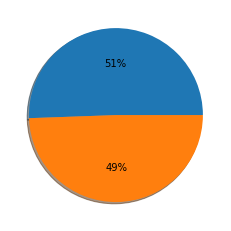

In [8]:
#Distribution of All Categories
plt.pie(distOfDetails['COUNT'],autopct='%1.0f%%',shadow=True, startangle=360)
plt.show()

In [9]:
# Text Preprocessing
columns = ['index', 'Class', 'Sentence']
df_ = pd.DataFrame(columns = columns)

# lower string
data['Sentence'] = data['Sentence'].str.lower()

# Remove email addresses
data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)

# Remove IP address
data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)

# Remove punctuations and special characters
data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')

# Remove numbers
data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)

# Remove stop words using NLTK
for index, row in data.iterrows():
    word_tokens = word_tokenize(row['Sentence'])
    filtered_sentence = [w for w in word_tokens if not w in stopwords.words('english')]
    df_ = df_.append({"index": row['index'], "Class":  row['Class'],"Sentence": " ".join(filtered_sentence[0:])}, ignore_index=True)
    
data = df_

In [10]:
# Display some data after text preprocessing
data

,index,Class,Sentence
0,0,0,way plug us unless go converter
1,1,1,good case excellent value
2,2,1,great jawbone
3,3,0,tied charger conversations lasting minutesmajo...
4,4,1,mic great
...,...,...,...
2743,743,0,got bored watching jessice lange take clothes
2744,744,0,unfortunately virtue films production work los...
2745,745,0,word embarrassing
2746,746,0,exceptionally bad


In [11]:
X_train, X_test, y_train, y_test = train_test_split(data['Sentence'].values.astype('U'),data['Class'].values.astype('int32'), test_size=0.10, random_state=0)
classes = data['Class'].unique()

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

# Grid search result

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,2), max_features=50000,max_df=0.5,use_idf=True, norm='l2') 
counts = vectorizer.fit_transform(X_train)
vocab = vectorizer.vocabulary_
# Stochastic Gradient Descent classifier
classifier = SGDClassifier(alpha=1e-05,max_iter=50,penalty='elasticnet')
targets = y_train
classifier = classifier.fit(counts, targets)
example_counts = vectorizer.transform(X_test)
predictions = classifier.predict(example_counts)

In [13]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

# Model Evaluation
acc = accuracy_score(y_test, predictions, normalize=True)
hit = precision_score(y_test, predictions, average=None,labels=classes)
capture = recall_score(y_test, predictions, average=None,labels=classes)


print('Model Accuracy:%.2f'%acc)
print(classification_report(y_test, predictions))

Model Accuracy:0.81
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       139
           1       0.82      0.79      0.80       136

    accuracy                           0.81       275
   macro avg       0.81      0.81      0.81       275
weighted avg       0.81      0.81      0.81       275



,Category,Index
0,0,1
1,1,2


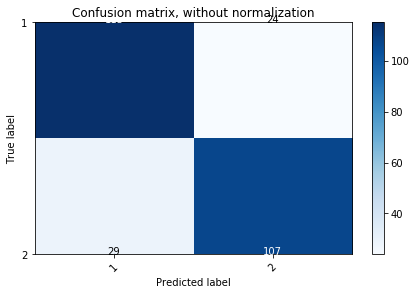

<Figure size 21.6x14.4 with 0 Axes>

In [14]:
#source: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print()
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(0.3,0.2))
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions,classes)
np.set_printoptions(precision=2)
class_names = range(1,classes.size+1)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
classInfo = pd.DataFrame(data=[])
for i in range(0,classes.size):
    classInfo = classInfo.append([[classes[i],i+1]],ignore_index=True)
classInfo.columns=['Category','Index']
classInfo

In [15]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predictions))

[[115  24]
 [ 29 107]]


In [22]:
# Let's try using the classifier to determine if a review/comment has positive or negative sentiments
# 1 means positive, whereas 0 means negative
test_1 = ['I loved it', 'I hated it', 'terrible food', 'awesome product']
test2 = vectorizer.transform(test_1)
classifier.predict(test2)

array([1, 0, 0, 1])